# [Explaining Text Classification](https://coderzcolumn.com/tutorials/artificial-intelligence/explain-text-classification-models-using-shap-values-keras)

In [20]:
from explainer.explainers import feature_attributions_explainer, metrics_explainer
feature_attributions_explainer.entry_points

EntryPoint(name='deepexplainer', value='feature_attributions_explainer:deep_explainer [labels,model,targetimages,backgroundimages]', group='explainer.explainers.feature_attributions_explainer')
EntryPoint(name='deeplift', value='feature_attributions_explainer:deeplift [model]', group='explainer.explainers.feature_attributions_explainer')
EntryPoint(name='gradientexplainer', value='feature_attributions_explainer:gradient_explainer', group='explainer.explainers.feature_attributions_explainer')
EntryPoint(name='integratedgradients', value='feature_attributions_explainer:integratedgradients [model]', group='explainer.explainers.feature_attributions_explainer')
EntryPoint(name='kernelexplainer', value='feature_attributions_explainer:kernel_explainer [model,data]', group='explainer.explainers.feature_attributions_explainer')
EntryPoint(name='partitionexplainer', value='feature_attributions_explainer:partition_explainer', group='explainer.explainers.feature_attributions_explainer')


In [21]:
import numpy as np
from sklearn import datasets

all_categories = ['alt.atheism','comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware',
                  'comp.sys.mac.hardware','comp.windows.x', 'misc.forsale','rec.autos','rec.motorcycles',
                  'rec.sport.baseball','rec.sport.hockey','sci.crypt','sci.electronics','sci.med',
                  'sci.space','soc.religion.christian','talk.politics.guns','talk.politics.mideast',
                  'talk.politics.misc','talk.religion.misc']

selected_categories = ['alt.atheism','comp.graphics','rec.motorcycles','sci.space','talk.politics.misc']

X_train_text, Y_train = datasets.fetch_20newsgroups(subset="train", categories=selected_categories, return_X_y=True)
X_test_text , Y_test  = datasets.fetch_20newsgroups(subset="test", categories=selected_categories, return_X_y=True)

X_train_text = np.array(X_train_text)
X_test_text = np.array(X_test_text)

classes = np.unique(Y_train)
mapping = dict(zip(classes, selected_categories))

len(X_train_text), len(X_test_text), classes, mapping

(2720,
 1810,
 array([0, 1, 2, 3, 4]),
 {0: 'alt.atheism',
  1: 'comp.graphics',
  2: 'rec.motorcycles',
  3: 'sci.space',
  4: 'talk.politics.misc'})

## Vectorize Text Data

In [22]:
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=50000)

vectorizer.fit(np.concatenate((X_train_text, X_test_text)))
X_train = vectorizer.transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

X_train, X_test = X_train.toarray(), X_test.toarray()

X_train.shape, X_test.shape

((2720, 50000), (1810, 50000))

## Define the Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def create_model():
    return Sequential([
                        layers.Input(shape=X_train.shape[1:]),
                        layers.Dense(128, activation="relu"),
                        layers.Dense(64, activation="relu"),
                        layers.Dense(len(classes), activation="softmax"),
                    ])

model = create_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               6400128   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 6,408,709
Trainable params: 6,408,709
Non-trainable params: 0
_________________________________________________________________


## Compile and Train Model

In [24]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, Y_train, batch_size=256, epochs=5, validation_data=(X_test, Y_test))

Epoch 1/5
11/11 [==============================] - 2s 163ms/step - loss: 1.5513 - accuracy: 0.5908 - val_loss: 1.4587 - val_accuracy: 0.7215
Epoch 2/5
11/11 [==============================] - 1s 118ms/step - loss: 1.2434 - accuracy: 0.8853 - val_loss: 1.1732 - val_accuracy: 0.8028
Epoch 3/5
11/11 [==============================] - 1s 98ms/step - loss: 0.7921 - accuracy: 0.9860 - val_loss: 0.8150 - val_accuracy: 0.9050
Epoch 4/5
11/11 [==============================] - 1s 107ms/step - loss: 0.3774 - accuracy: 0.9974 - val_loss: 0.5230 - val_accuracy: 0.9459
Epoch 5/5
11/11 [==============================] - 1s 86ms/step - loss: 0.1480 - accuracy: 1.0000 - val_loss: 0.3622 - val_accuracy: 0.9481


## Evaluate Model Performance

In [25]:
from sklearn.metrics import accuracy_score, classification_report

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("Train Accuracy : {:.3f}".format(accuracy_score(Y_train, np.argmax(train_preds, axis=1))))
print("Test  Accuracy : {:.3f}".format(accuracy_score(Y_test, np.argmax(test_preds, axis=1))))
print("\nClassification Report : ")
print(classification_report(Y_test, np.argmax(test_preds, axis=1), target_names=selected_categories))

57/57 [==============================] - 1s 8ms/step
Train Accuracy : 1.000
Test  Accuracy : 0.948

Classification Report : 
                    precision    recall  f1-score   support

       alt.atheism       0.96      0.94      0.95       319
     comp.graphics       0.91      0.97      0.94       389
   rec.motorcycles       0.97      0.99      0.98       398
         sci.space       0.95      0.92      0.94       394
talk.politics.misc       0.95      0.91      0.93       310

          accuracy                           0.95      1810
         macro avg       0.95      0.95      0.95      1810
      weighted avg       0.95      0.95      0.95      1810



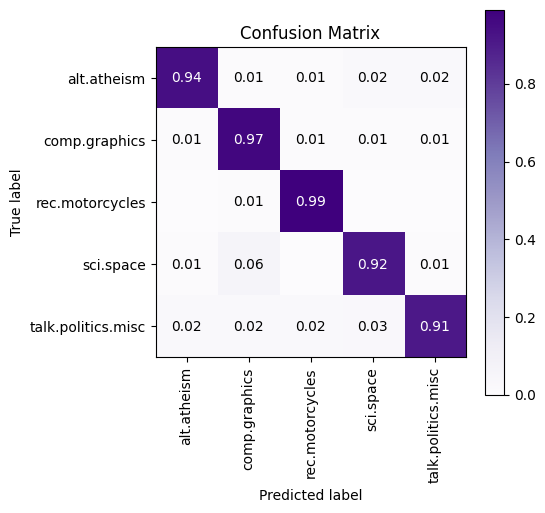

In [26]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt

plot = skplt.metrics.plot_confusion_matrix([selected_categories[i] for i in Y_test], [selected_categories[i] for i in np.argmax(test_preds, axis=1)],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

## SHAP Partition Explainer

In [27]:
partitionexplainer = feature_attributions_explainer['partitionexplainer']
print(partitionexplainer.__doc__)
shap =  partitionexplainer().shap
def make_predictions(X_batch_text):
    X_batch = vectorizer.transform(X_batch_text).toarray()
    preds = model.predict(X_batch)
    return preds

masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions, masker=masker, output_names=selected_categories)

explainer


     Sets up a SHAP PartitionExplainer

     Returns:
       PartitionExplainer
  


## Visualize SHAP Values Correct Predictions

In [28]:
import re

X_batch_text = X_test_text[1:3]
X_batch = X_test[1:3]

print("Samples : ")
for text in X_batch_text:
    print(re.split(r"\W+", text))
    print()

preds_proba = model.predict(X_batch)
preds = preds_proba.argmax(axis=1)

# print("Actual    Target Values : {}".format([selected_categories[target] for target in Y_test[1:3]]))
# print("Predicted Target Values : {}".format([selected_categories[target] for target in preds]))
# print("Predicted Probabilities : {}".format(preds_proba.max(axis=1)))

shap_values = explainer(X_batch_text)

Samples : 
['From', 'prb', 'access', 'digex', 'net', 'Pat', 'Subject', 'Re', 'Near', 'Miss', 'Asteroids', 'Q', 'Organization', 'Express', 'Access', 'Online', 'Communications', 'Greenbelt', 'MD', 'USA', 'Lines', '4', 'Distribution', 'sci', 'NNTP', 'Posting', 'Host', 'access', 'digex', 'net', 'TRry', 'the', 'SKywatch', 'project', 'in', 'Arizona', 'pat', '']

['From', 'cobb', 'alexia', 'lis', 'uiuc', 'edu', 'Mike', 'Cobb', 'Subject', 'Science', 'and', 'theories', 'Organization', 'University', 'of', 'Illinois', 'at', 'Urbana', 'Lines', '19', 'As', 'per', 'various', 'threads', 'on', 'science', 'and', 'creationism', 'I', 've', 'started', 'dabbling', 'into', 'a', 'book', 'called', 'Christianity', 'and', 'the', 'Nature', 'of', 'Science', 'by', 'JP', 'Moreland', 'A', 'question', 'that', 'I', 'had', 'come', 'from', 'one', 'of', 'his', 'comments', 'He', 'stated', 'that', 'God', 'is', 'not', 'necessarily', 'a', 'religious', 'term', 'but', 'could', 'be', 'used', 'as', 'other', 'scientific', 'terms'

  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 69ms/step


Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 65ms/step


Partition explainer: 3it [00:36, 18.04s/it]               


### Text Plot

In [29]:
shap.text_plot(shap_values)

### Bar Plots

#### Bar Plot 1

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


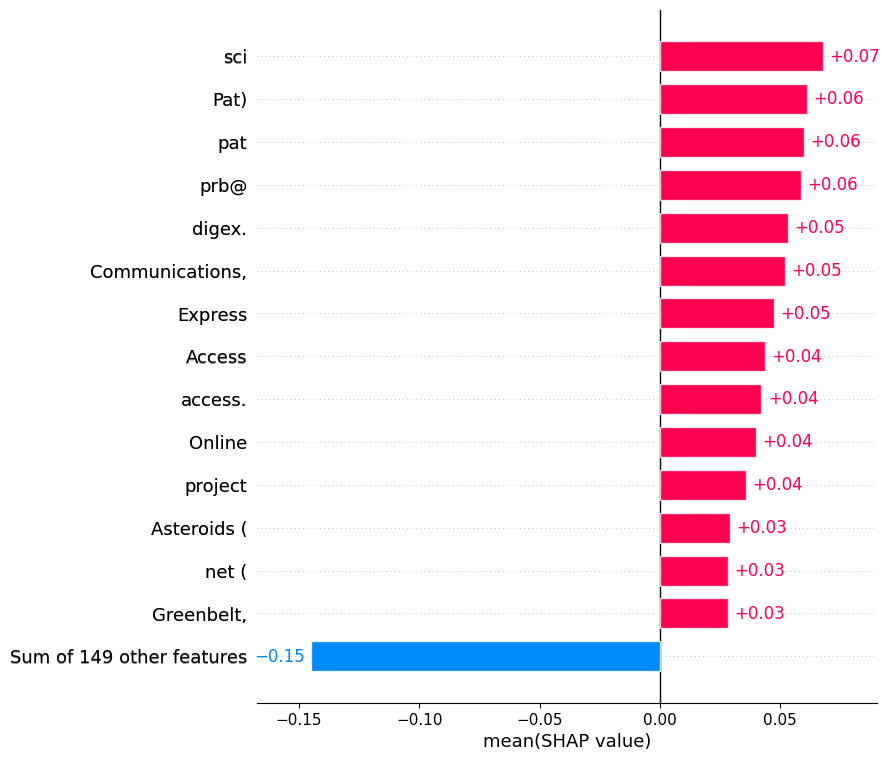

In [30]:
shap.plots.bar(shap_values[:,:, selected_categories[preds[0]]].mean(axis=0), max_display=15,
               order=shap.Explanation.argsort.flip)

#### Bar Plot 2

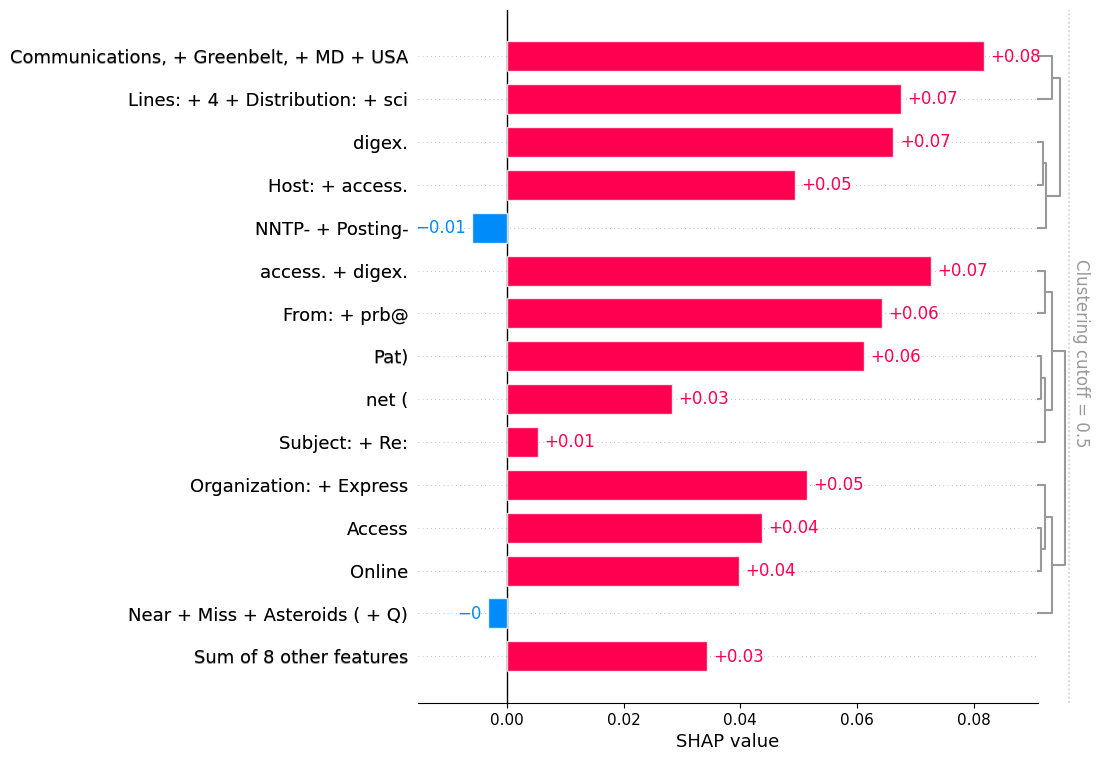

In [31]:
shap.plots.bar(shap_values[0,:, selected_categories[preds[0]]], max_display=15,
               order=shap.Explanation.argsort.flip)

### Bar Plot 3

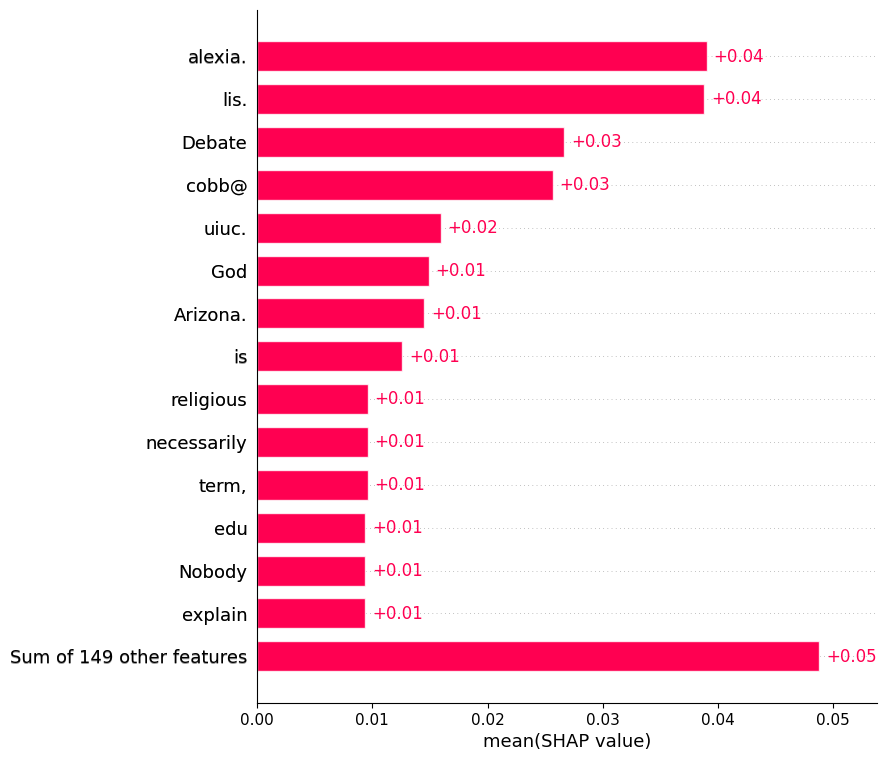

In [32]:
shap.plots.bar(shap_values[:,:, selected_categories[preds[1]]].mean(axis=0), max_display=15,
               order=shap.Explanation.argsort.flip)

### Bar Plot 4

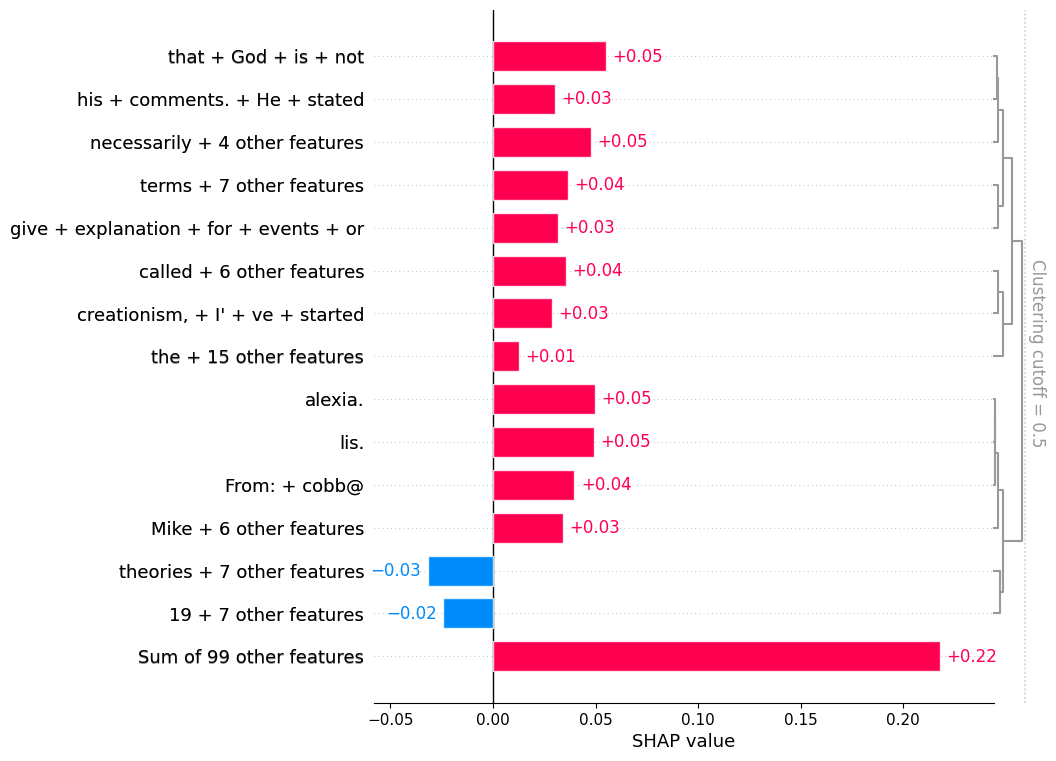

In [33]:
shap.plots.bar(shap_values[1,:, selected_categories[preds[1]]], max_display=15,
               order=shap.Explanation.argsort.flip)

## Waterfall Plots

### Waterfall Plot 1

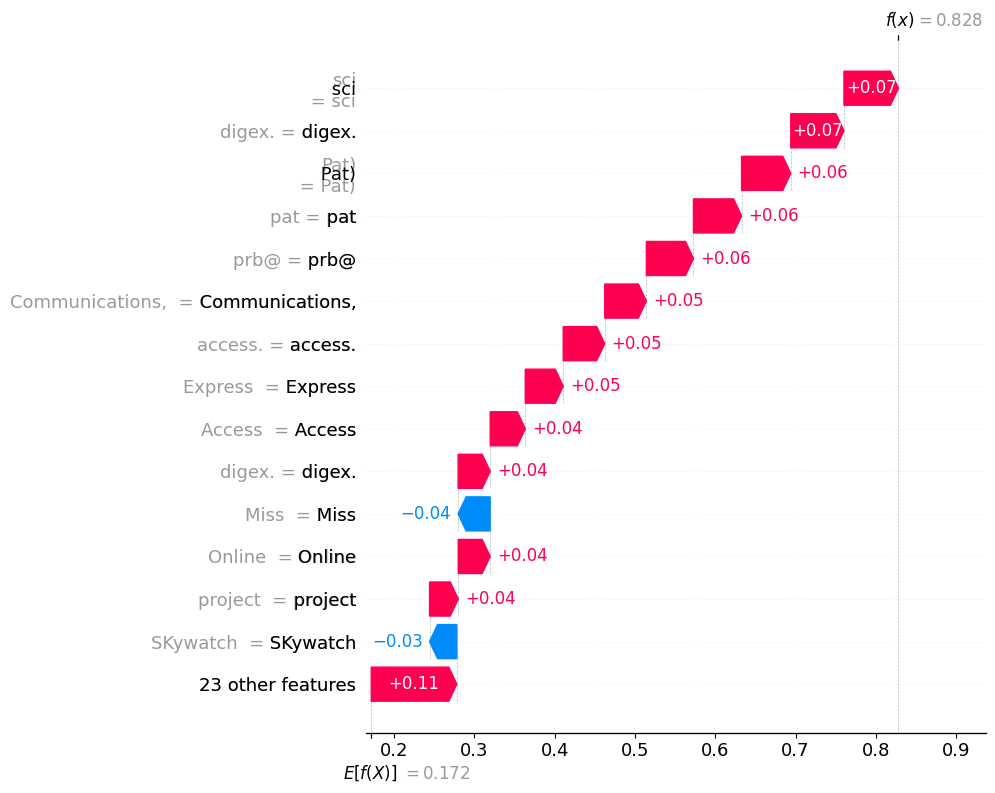

In [34]:
shap.waterfall_plot(shap_values[0][:, selected_categories[preds[0]]], max_display=15)

### Waterfall Plot 2

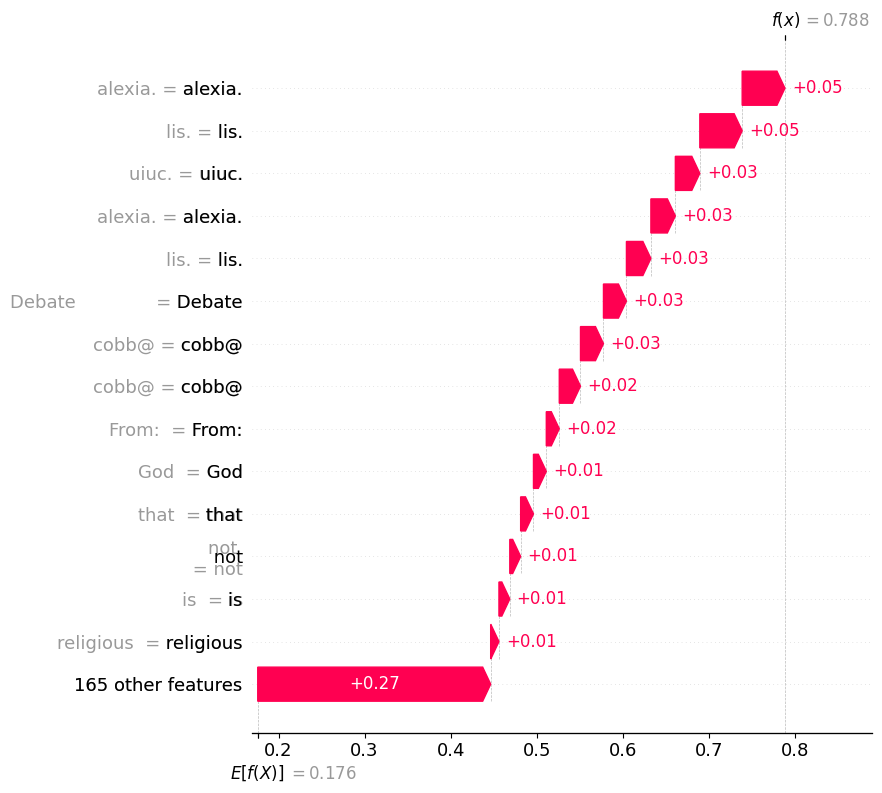

In [35]:
shap.waterfall_plot(shap_values[1][:, selected_categories[preds[1]]], max_display=15)

## Force Plot

In [40]:
import re
tokens = re.split("\W+", X_batch_text[0].lower())
shap.initjs()
shap.force_plot(shap_values.base_values[0][preds[0]], shap_values[0][:, preds[0]].values,
                feature_names = tokens[:-1], out_names=selected_categories[preds[0]])